# Understand Ranking Metrics for Job Recommendations

### Challenge:

This is a basic exercise about a fundamental step in producing a ML system: scoring the performance. The general frame is about recommending jobs to a user that visits one of our customers' career page and it's already seeing one particular job.

To help in the development of such system, our Data Analyst has produced a „gold standard“ where she has manually determined, for a specific client, which jobs should be recommended for each job.

This info is stored in the file "gold_standard.json" using the following format:

  [{"job":"265678",
  „reccs":["285846","177721","282184","21999","29911","285285","106087","280890"]},
  ...]

Where "job" contains the id of the current job, and "reccs" the ids of the recommended ones (recommended jobs are ranked from more to less similar, but feel free to ignore the "ranking" information).

Additionally, we have already produced a similarity matrix, which contains a similarity score between each of the 19 jobs in the system: "similarJobs.csv".

Your job here is to score the algorithm. Discuss the process that you would follow in producing that score and which questions do arise during this process. Just for clarity, you will have to decide first, how to generate a "score-able" result from this similarity matrix.



### Approach:

    1. Install virtual environment
            
            pipenv install
            pipenv run jupyter-notebook
            
            
    2. Read supplied data
    3. Create dummy data
    4. Create metrics to score ranking algorithm
    5. Understand algorithm performance based on ranking metric
    6. Decide on "best" metric

In [1]:
from math import log2
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import coverage_error
from IPython.display import Image

import job_rec_helpers as jr

## 2. Read and explore supplied data

#### Define file paths:

In [2]:
job_ads_path = 'data/jobs.json'
gold_standard_path = 'data/gold_standard.json'
similar_jobs_path = 'data/similarJobs.csv'

In [3]:
similarity_cutoff = 0.0

### Jobs.json:

In [4]:
job_ads_df = pd.read_json(job_ads_path).reset_index().rename(
    columns={'index': 'job_id'})
print(f"{len(job_ads_df)} data points in df.\nJob ads DF:")
job_ads_df.head()

19 data points in df.
Job ads DF:


job_id                                              title  \
0  265678        ACCOUNT SALES MANAGER (ALL GENDERS) - JAPAN   
1  106087  BUSINESS CLIENT SERVICES MANAGER (ALL GENDERS)...   
2  280890              COUNTRY HEAD (ALL GENDERS) - MALAYSIA   
3  285285          EMS PRODUCT SPECIALIST EMEA (ALL GENDERS)   
4   21999            EVENT & MARKETING MANAGER (ALL GENDERS)   

                                         description  
0  <ul><li>Manage clients in the dedicated sales ...  
1  <ul><li>Provide first class and pro-active cli...  
2  <p>Based in Malaysia, you will be part of an I...  
3  <ul><li>Drive and support Growth of 360T’s wor...  
4  <p><strong>Event Management </strong></p>\n\n<...

The jobs.json data file contains tabular data with a column for job id, a title and descriptions as text.

### Gold Standard DF:

In [5]:
gold_standard_df = pd.read_json(gold_standard_path).rename(
    columns={'job': 'job_id'})
gold_standard_df = jr.fix_recs(gold_standard_df)
print(f"{len(gold_standard_df)} data points in df.\nGold Standard DF:")
gold_standard_df.head()

19 data points in df.
Gold Standard DF:


job_id                                               recs
0  265678  [285846, 177721, 282184, 21999, 29911, 285285,...
1  106087      [285846, 21999, 285308, 22934, 16459, 285285]
2  280890                   [177721, 265678, 286967, 285285]
3  285285  [21999, 29911, 286967, 282184, 285846, 106087,...
4   21999  [29911, 285846, 286967, 265678, 282184, 177721...

We can see each job is linked to a list of recommended job ids. These are hand crafted and serve as the desired recomendations for each job id.

### Similarity Matrix:

In [6]:
job_similarity_supplied = pd.read_csv(similar_jobs_path, index_col=0)
print(
    f"{len(job_similarity_supplied)} data points in df.\nSupplied similarity DF:"
)
job_similarity_supplied_org = job_similarity_supplied.copy()
job_similarity_supplied.head(len(job_similarity_supplied))

19 data points in df.
Supplied similarity DF:


265678  106087  280890  285285  21999  286967  16450  240741  282184  \
265678   1.000   0.000   0.000   0.000  0.260   0.054  0.000   0.000   0.292   
106087   0.000   1.000   0.087   0.039  0.024   0.000  0.000   0.000   0.097   
280890   0.000   0.087   1.000   0.131  0.000   0.122  0.103   0.066   0.292   
285285   0.000   0.039   0.131   1.000  0.425   0.000  0.000   0.000   0.142   
21999    0.260   0.024   0.000   0.425  1.000   0.104  0.000   0.000   0.333   
286967   0.054   0.000   0.122   0.000  0.104   1.000  0.000   0.000   0.000   
16450    0.000   0.000   0.103   0.000  0.000   0.000  1.000   0.086   0.000   
240741   0.000   0.000   0.066   0.000  0.000   0.000  0.086   1.000   0.000   
282184   0.292   0.097   0.292   0.142  0.333   0.000  0.000   0.000   1.000   
285846   0.538   0.000   0.153   0.000  0.206   0.322  0.000   0.000   0.457   
177721   0.285   0.000   0.309   0.000  0.226   0.253  0.000   0.000   0.625   
29911    0.033   0.026   0.081   0.450  0.285   0.150  0.000   0.000   0.102   
240740   0.000   0.000   0.066   0.000  0.000   0.000  0.086   1.000   0.000   
22934    0.000   0.097   0.073   0.000  0.000   0.000  0.057   0.167   0.000   
285308   0.155   0.127   0.103   0.000  0.000   0.000  0.000   0.000   0.000   
16459    0.042   0.000   0.000   0.000  0.135   0.000  0.000   0.000   0.135   
36458    0.000   0.106   0.081   0.000  0.000   0.138  0.000   0.000   0.092   
16462    0.000   0.000   0.000   0.000  0.000   0.000  0.171   0.325   0.000   
268353   0.000   0.000   0.000   0.000  0.000   0.000  0.589   0.112   0.000   

        285846  177721  29911  240740  22934  285308  16459  36458  16462  \
265678   0.538   0.285  0.033   0.000  0.000   0.155  0.042  0.000  0.000   
106087   0.000   0.000  0.026   0.000  0.097   0.127  0.000  0.106  0.000   
280890   0.153   0.309  0.081   0.066  0.073   0.103  0.000  0.081  0.000   
285285   0.000   0.000  0.450   0.000  0.000   0.000  0.000  0.000  0.000   
21999    0.206   0.226  0.285   0.000  0.000   0.000  0.135  0.000  0.000   
286967   0.322   0.253  0.150   0.000  0.000   0.000  0.000  0.138  0.000   
16450    0.000   0.000  0.000   0.086  0.057   0.000  0.000  0.000  0.171   
240741   0.000   0.000  0.000   1.000  0.167   0.000  0.000  0.000  0.325   
282184   0.457   0.625  0.102   0.000  0.000   0.000  0.135  0.092  0.000   
285846   1.000   0.696  0.024   0.000  0.000   0.000  0.032  0.000  0.000   
177721   0.696   1.000  0.085   0.000  0.000   0.000  0.118  0.000  0.000   
29911    0.024   0.085  1.000   0.000  0.000   0.000  0.133  0.000  0.000   
240740   0.000   0.000  0.000   1.000  0.167   0.000  0.000  0.000  0.325   
22934    0.000   0.000  0.000   0.167  1.000   0.452  0.000  0.183  0.283   
285308   0.000   0.000  0.000   0.000  0.452   1.000  0.000  0.121  0.171   
16459    0.032   0.118  0.133   0.000  0.000   0.000  1.000  0.000  0.000   
36458    0.000   0.000  0.000   0.000  0.183   0.121  0.000  1.000  0.225   
16462    0.000   0.000  0.000   0.325  0.283   0.171  0.000  0.225  1.000   
268353   0.000   0.000  0.000   0.112  0.250   0.196  0.000  0.000  0.450   

        268353  
265678   0.000  
106087   0.000  
280890   0.000  
285285   0.000  
21999    0.000  
286967   0.000  
16450    0.589  
240741   0.112  
282184   0.000  
285846   0.000  
177721   0.000  
29911    0.000  
240740   0.112  
22934    0.250  
285308   0.196  
16459    0.000  
36458    0.000  
16462    0.450  
268353   1.000

The job similarity matrix seen here, shows a similarity score for each job id. As such the matrix contains ones in the diagonal and is symmetric.

## 3. Create dummy data
The dummy data will be necessary to compare the metric scores, by evaluating the "gold standard" to noisy and random similarity data.
### Add noise to similarity data

In [7]:
job_similarity_some_noise = jr.rand_noise_to_df(job_similarity_supplied, 10)
job_similarity_some_noise.head()

265678   106087  280890   285285    21999   286967    16450  240741  \
265678  1.0000  0.00000   0.000  0.00000  0.23920  0.05454  0.00000  0.0000   
106087  0.0000  1.00000   0.087  0.04095  0.02280  0.00000  0.00000  0.0000   
280890  0.0000  0.08613   1.000  0.12314  0.00000  0.11468  0.10609  0.0594   
285285  0.0000  0.04095   0.131  1.00000  0.42075  0.00000  0.00000  0.0000   
21999   0.2418  0.02328   0.000  0.43350  1.00000  0.09672  0.00000  0.0000   

         282184   285846   177721    29911   240740    22934   285308  \
265678  0.29492  0.54876  0.28785  0.03267  0.00000  0.00000  0.14880   
106087  0.09506  0.00000  0.00000  0.02574  0.00000  0.10573  0.13843   
280890  0.28032  0.14841  0.30591  0.08019  0.06666  0.06789  0.10609   
285285  0.13916  0.00000  0.00000  0.42750  0.00000  0.00000  0.00000   
21999   0.32634  0.21012  0.21018  0.25935  0.00000  0.00000  0.00000   

          16459    36458  16462  268353  
265678  0.03948  0.00000    0.0     0.0  
106087  0.00000  0.10388    0.0     0.0  
280890  0.00000  0.07533    0.0     0.0  
285285  0.00000  0.00000    0.0     0.0  
21999   0.14040  0.00000    0.0     0.0

In [8]:
job_similarity_much_noise = jr.rand_noise_to_df(job_similarity_supplied,25)
job_similarity_much_noise.head()

265678   106087  280890   285285    21999   286967    16450   240741  \
265678  1.0000  0.00000  0.0000  0.00000  0.20540  0.04104  0.00000  0.00000   
106087  0.0000  1.00000  0.0957  0.04602  0.02112  0.00000  0.00000  0.00000   
280890  0.0000  0.10788  1.0000  0.13755  0.00000  0.12444  0.10094  0.05082   
285285  0.0000  0.04602  0.1179  1.00000  0.37400  0.00000  0.00000  0.00000   
21999   0.2782  0.02352  0.0000  0.36975  1.00000  0.12584  0.00000  0.00000   

         282184  285846   177721    29911   240740    22934   285308    16459  \
265678  0.26572  0.4842  0.33060  0.02673  0.00000  0.00000  0.15965  0.03444   
106087  0.11446  0.0000  0.00000  0.03224  0.00000  0.08536  0.15494  0.00000   
280890  0.27448  0.1377  0.35226  0.07047  0.06468  0.08030  0.08652  0.00000   
285285  0.15052  0.0000  0.00000  0.50850  0.00000  0.00000  0.00000  0.00000   
21999   0.33300  0.2266  0.17402  0.26220  0.00000  0.00000  0.00000  0.12690   

         36458  16462  268353  
265678  0.0000    0.0     0.0  
106087  0.0848    0.0     0.0  
280890  0.0648    0.0     0.0  
285285  0.0000    0.0     0.0  
21999   0.0000    0.0     0.0

### Create random similarity data:

In [9]:
rand_job_similarity = jr.create_rand_similarity_df(
    -40, 100, list(job_similarity_supplied.shape),
    job_similarity_supplied.index, job_similarity_supplied.columns)
rand_job_similarity

265678  106087  280890  285285  21999  286967  16450  240741  282184  \
265678    1.00    0.00    0.87    0.97   0.87    0.43   0.00    0.00    0.00   
106087    0.60    1.00    0.23    0.00   0.00    0.00   0.23    0.78    0.82   
280890    0.22    0.42    1.00    0.00   0.17    0.03   0.00    0.00    0.26   
285285    0.79    0.00    0.79    1.00   0.00    0.30   0.29    0.17    0.69   
21999     0.59    0.61    0.23    0.23   1.00    0.25   0.65    0.89    0.20   
286967    0.23    0.36    0.94    0.84   0.00    1.00   0.80    0.36    0.38   
16450     0.50    0.00    0.36    0.48   0.88    0.00   1.00    0.79    0.50   
240741    0.84    0.46    0.88    0.84   0.18    0.08   0.00    1.00    0.15   
282184    0.00    0.21    0.98    0.70   0.11    0.55   0.07    0.00    1.00   
285846    0.25    0.00    0.00    0.03   0.07    0.22   0.00    0.41    0.50   
177721    0.00    0.00    0.86    0.00   0.54    0.58   0.00    0.76    0.53   
29911     0.12    0.00    0.17    0.19   0.00    0.00   0.00    0.60    0.57   
240740    0.16    0.57    0.00    0.00   0.24    0.89   0.00    0.00    0.69   
22934     0.00    0.00    0.08    0.40   0.00    0.44   0.30    0.04    0.82   
285308    0.37    0.85    0.37    0.20   0.83    0.49   0.00    0.54    0.00   
16459     0.63    0.77    0.00    0.09   0.00    0.78   0.18    0.82    0.00   
36458     0.11    0.00    0.24    0.31   0.75    0.05   0.88    0.71    0.18   
16462     0.05    0.46    0.00    0.40   0.25    0.99   0.75    0.38    0.00   
268353    0.16    0.85    0.69    0.63   0.00    0.77   0.30    0.00    0.00   

        285846  177721  29911  240740  22934  285308  16459  36458  16462  \
265678    0.00    0.00   0.00    0.97   0.00    0.00   0.82   0.82   0.67   
106087    0.42    0.85   0.45    0.00   0.86    0.68   0.50   0.31   0.85   
280890    0.00    0.12   0.00    0.00   0.59    0.27   0.17   0.94   0.00   
285285    0.28    0.00   0.00    0.08   0.25    0.00   0.18   0.48   0.33   
21999     0.38    0.00   0.69    0.00   0.42    0.00   0.44   0.00   0.00   
286967    0.14    0.75   0.47    0.00   0.98    0.67   0.32   0.98   0.00   
16450     0.55    0.00   0.14    0.34   0.04    0.00   0.00   0.00   0.49   
240741    0.00    0.00   0.52    0.88   0.94    0.47   0.94   0.08   0.20   
282184    0.70    0.19   0.00    0.71   0.66    0.32   0.86   0.13   0.28   
285846    1.00    0.66   0.00    0.64   0.33    0.00   0.44   0.00   0.82   
177721    0.00    1.00   0.00    0.35   0.76    0.00   0.11   0.00   0.41   
29911     0.99    0.95   1.00    0.79   0.25    0.08   0.91   0.99   0.00   
240740    0.22    0.80   0.54    1.00   0.47    0.00   0.00   0.53   0.00   
22934     0.04    0.28   0.00    0.72   1.00    0.00   0.94   0.86   0.78   
285308    0.00    0.47   0.73    0.48   0.07    1.00   0.91   0.70   0.86   
16459     0.47    0.19   0.00    0.65   0.00    0.53   1.00   0.16   0.95   
36458     0.60    0.00   0.19    0.95   0.00    0.60   0.02   1.00   0.15   
16462     0.00    0.00   0.00    0.10   0.00    0.45   0.72   0.81   1.00   
268353    0.83    0.00   0.99    0.00   0.08    0.00   0.00   0.07   0.00   

        268353  
265678    0.70  
106087    0.80  
280890    0.84  
285285    0.56  
21999     0.87  
286967    0.00  
16450     0.00  
240741    0.00  
282184    0.00  
285846    0.93  
177721    0.00  
29911     0.01  
240740    0.00  
22934     0.49  
285308    0.28  
16459     0.21  
36458     0.80  
16462     0.63  
268353    1.00

### Function from similarity Matrix to Ranks:

In [10]:
small_simi = job_similarity_supplied.iloc[0:5, 0:5]
small_simi

265678  106087  280890  285285  21999
265678    1.00   0.000   0.000   0.000  0.260
106087    0.00   1.000   0.087   0.039  0.024
280890    0.00   0.087   1.000   0.131  0.000
285285    0.00   0.039   0.131   1.000  0.425
21999     0.26   0.024   0.000   0.425  1.000

In [11]:
ranks_df = jr.simi_vals2recs(small_simi, similarity_cutoff)
ranks_df.head()

job_id                       score_list  \
265678  265678       [1.0, 0.0, 0.0, 0.0, 0.26]   
106087  106087  [0.0, 1.0, 0.087, 0.039, 0.024]   
280890  280890    [0.0, 0.087, 1.0, 0.131, 0.0]   
285285  285285  [0.0, 0.039, 0.131, 1.0, 0.425]   
21999    21999   [0.26, 0.024, 0.0, 0.425, 1.0]   

                                    recs  
265678   [21999, 285285, 280890, 106087]  
106087   [280890, 285285, 21999, 265678]  
280890   [285285, 106087, 265678, 21999]  
285285   [21999, 280890, 106087, 265678]  
21999   [285285, 265678, 106087, 280890]

In [12]:
ranks_by_job_similarity = jr.simi_vals2recs(job_similarity_supplied,
                                            similarity_cutoff)
ranks_by_job_similarity.head()

job_id                                         score_list  \
265678  265678  [1.0, 0.0, 0.0, 0.0, 0.26, 0.054, 0.0, 0.0, 0....   
106087  106087  [0.0, 1.0, 0.087, 0.039, 0.024, 0.0, 0.0, 0.0,...   
280890  280890  [0.0, 0.087, 1.0, 0.131, 0.0, 0.122, 0.103, 0....   
285285  285285  [0.0, 0.039, 0.131, 1.0, 0.425, 0.0, 0.0, 0.0,...   
21999    21999  [0.26, 0.024, 0.0, 0.425, 1.0, 0.104, 0.0, 0.0...   

                                                     recs  
265678  [285846, 282184, 177721, 21999, 285308, 286967...  
106087  [285308, 36458, 282184, 22934, 280890, 285285,...  
280890  [177721, 282184, 285846, 285285, 286967, 28530...  
285285  [29911, 21999, 282184, 280890, 106087, 286967,...  
21999   [285285, 282184, 29911, 265678, 177721, 285846...

In [13]:
gold_standard_df.head()

job_id                                               recs
0  265678  [285846, 177721, 282184, 21999, 29911, 285285,...
1  106087      [285846, 21999, 285308, 22934, 16459, 285285]
2  280890                   [177721, 265678, 286967, 285285]
3  285285  [21999, 29911, 286967, 282184, 285846, 106087,...
4   21999  [29911, 285846, 286967, 265678, 282184, 177721...

# Calculate Metrics:
Here, we assume, we only care about a list of recommended jobs, not taking the rank position into account.

In [14]:
def calc_rank_metrics(true_df, pred_ranks_df):
    """Here we calculate some metrics of the ranked recommendations, compared to the gold standard (true).
    Precision is defined as n relevant jobs retrieved adevided by n jobs retrieved in total.
    The number describes how well we only retrieve relevant jobs.
    Recall is defined as n relevant jobs retrieved devided by n relevant jobs in total.
    This number describes the ability to find all relevant jobs.
    F-Measure takes both recall and precision into account.
    E Measure (parameterized F Measure) beta > 1: Weight recall more, beta < 1: Weight precision more."""

    def number_of_relevant_jobs_retrieved(true_list, pred_list):
        return len(set(true_list) & set(pred_list))

    job_ids_true = true_df['job_id'].to_list()
    job_ids_pred = pred_ranks_df['job_id'].to_list()

    job_ids_in_both = list(set(job_ids_true) & set(job_ids_pred))

    #We filter, using only ids found in both DFs, and sort by ID
    true_df = true_df[true_df['job_id'].isin(job_ids_in_both)].sort_values(
        by='job_id')
    pred_ranks_df = pred_ranks_df[pred_ranks_df['job_id'].isin(
        job_ids_in_both)].sort_values(by='job_id')

    true_ranks = true_df['recs'].to_list()
    pred_ranks = pred_ranks_df['recs'].to_list()

    n_rel_jobs = []
    n_jobs_retrieved = []
    n_rel_jobs_retrieved = []

    for tr, pr in zip(true_ranks, pred_ranks):
        n_rel_jobs.append(len(tr))
        n_jobs_retrieved.append(len(pr))
        n_rel_jobs_retrieved.append(number_of_relevant_jobs_retrieved(tr, pr))

    pred_ranks_df['n_rel_jobs'] = n_rel_jobs
    pred_ranks_df['n_jobs_retrieved'] = n_jobs_retrieved
    pred_ranks_df['n_rel_jobs_retrieved'] = n_rel_jobs_retrieved

    pred_ranks_df['recall'] = pred_ranks_df[
        'n_rel_jobs_retrieved'] / pred_ranks_df['n_rel_jobs']
    pred_ranks_df['precision'] = pred_ranks_df[
        'n_rel_jobs_retrieved'] / pred_ranks_df['n_jobs_retrieved']

    pred_ranks_df['F_measure'] = 2 / ((1 / pred_ranks_df['recall']) +
                                      (1 / pred_ranks_df['precision']))
    #Beta at 0.5,  beta > 1: Weight recall more, beta < 1: Weight precision more.
    beta = 0.5
    pred_ranks_df['E_measure'] = (1 + beta**2) / (
        (beta**2 / pred_ranks_df['recall']) + (1 / pred_ranks_df['precision']))

    return pred_ranks_df[[
        'job_id', 'precision', 'recall', 'F_measure', 'E_measure'
    ]]

In [15]:
pred_metrics = calc_rank_metrics(gold_standard_df, ranks_by_job_similarity)
pred_metrics[['job_id', 'precision', 'recall']]

job_id  precision    recall
16450    16450   0.222222  1.000000
16459    16459   0.277778  1.000000
16462    16462   0.222222  1.000000
21999    21999   0.444444  1.000000
22934    22934   0.166667  1.000000
29911    29911   0.444444  1.000000
36458    36458   0.222222  1.000000
106087  106087   0.333333  1.000000
177721  177721   0.444444  1.000000
240740  240740   0.111111  0.666667
240741  240741   0.277778  1.000000
265678  265678   0.444444  1.000000
268353  268353   0.333333  1.000000
280890  280890   0.222222  1.000000
282184  282184   0.388889  1.000000
285285  285285   0.444444  1.000000
285308  285308   0.222222  1.000000
285846  285846   0.388889  1.000000
286967  286967   0.444444  1.000000

In [16]:
pred_metrics[['job_id', 'precision', 'recall', 'F_measure', 'E_measure']]

job_id  precision    recall  F_measure  E_measure
16450    16450   0.222222  1.000000   0.363636   0.263158
16459    16459   0.277778  1.000000   0.434783   0.324675
16462    16462   0.222222  1.000000   0.363636   0.263158
21999    21999   0.444444  1.000000   0.615385   0.500000
22934    22934   0.166667  1.000000   0.285714   0.200000
29911    29911   0.444444  1.000000   0.615385   0.500000
36458    36458   0.222222  1.000000   0.363636   0.263158
106087  106087   0.333333  1.000000   0.500000   0.384615
177721  177721   0.444444  1.000000   0.615385   0.500000
240740  240740   0.111111  0.666667   0.190476   0.133333
240741  240741   0.277778  1.000000   0.434783   0.324675
265678  265678   0.444444  1.000000   0.615385   0.500000
268353  268353   0.333333  1.000000   0.500000   0.384615
280890  280890   0.222222  1.000000   0.363636   0.263158
282184  282184   0.388889  1.000000   0.560000   0.443038
285285  285285   0.444444  1.000000   0.615385   0.500000
285308  285308   0.222222  1.000000   0.363636   0.263158
285846  285846   0.388889  1.000000   0.560000   0.443038
286967  286967   0.444444  1.000000   0.615385   0.500000

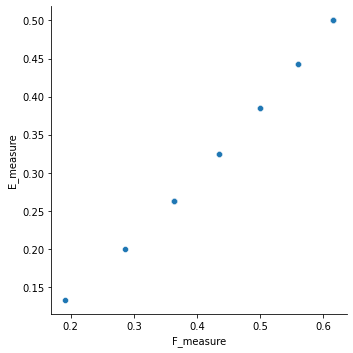

In [17]:
sns.relplot(
    data=pred_metrics,
    x="F_measure",
    y="E_measure",
)

## So time to get down to a single number:

In [18]:
score_base_similarity_matrix = pred_metrics['E_measure'].mean()
print(
    f"Our metric for the similarity matrix is: {score_base_similarity_matrix:.3f}!"
)

Our metric for the similarity matrix is: 0.366!


## What does this tell us???

To understand what this number now tells us, we have to compare it to something. How about to the noisy and random similarity matrix data:

In [19]:
#We will run a few loops, to take some randomness out of this small analysis:
n_loops = 20
some_noise_metric = 0
much_noise_metric = 0
random_matrix_metric = 0

for i in range(n_loops):
    job_similarity_some_noise = jr.rand_noise_to_df(
        job_similarity_supplied_org, 5)
    some_noise_df = jr.simi_vals2recs(job_similarity_some_noise,
                                      similarity_cutoff)
    pred_metrics_some_noise = calc_rank_metrics(gold_standard_df,
                                                some_noise_df)
    some_noise_metric += pred_metrics_some_noise['E_measure'].mean()

    job_similarity_much_noise = jr.rand_noise_to_df(
        job_similarity_supplied_org, 30)
    much_noise_df = jr.simi_vals2recs(job_similarity_much_noise,
                                      similarity_cutoff)
    pred_metrics_much_noise = calc_rank_metrics(gold_standard_df,
                                                much_noise_df)
    much_noise_metric += pred_metrics_much_noise['E_measure'].mean()

    rand_job_similarity = jr.create_rand_similarity_df(
        -40, 100, list(job_similarity_supplied.shape),
        job_similarity_supplied.index, job_similarity_supplied.columns)
    rand_ranks_df2 = jr.simi_vals2recs(rand_job_similarity, similarity_cutoff)
    pred_metrics_rand = calc_rank_metrics(gold_standard_df, rand_ranks_df2)
    random_matrix_metric += pred_metrics_rand['E_measure'].mean()

some_noise_metric /= n_loops
much_noise_metric /= n_loops
random_matrix_metric /= n_loops
print(
    f"Our metric for a noisy similarity matrix: \t\t\t\t{some_noise_metric:.16f}"
)
print(
    f"Our metric for very noisy similarity matrix: \t\t\t\t{much_noise_metric:.16f}"
)
print(
    f"Our metric for a random similarity matrix: \t\t\t\t{random_matrix_metric:.16f}"
)

print(
    f"\nCompare that to our initial value from our supplied similarity matrix: \t{score_base_similarity_matrix:.16f}"
)

Our metric for a noisy similarity matrix: 				0.3680936934192658
Our metric for very noisy similarity matrix: 				0.3679182548227745
Our metric for a random similarity matrix: 				0.3694972021911955

Compare that to our initial value from our supplied similarity matrix: 	0.3659884302613711


# Custom Metric
Lets assume, we only want to have two jobs listed below the main job ad:

In [20]:
Image(url="job_img.jpg", width=300)

As, we are only using two jobs, once more we do not care about the rank of the jobs. But the similarity matrix should help to find the two jobs that are the first two of the gold standard. So we do want the first two jobs, however if they are displayed as 1-2 or 2-1 does not matter.

In [21]:
def calc_two_choice_metric(true_df, pred_ranks_df, matches=2):
    """Calculates if in the recommended first two choices,
    we see the first two choices according to the true ranks
    0 points for no matches,
    0.5 point for one match
    1 point for two matches."""

    def number_of_relevant_jobs_retrieved(true_list, pred_list):
        return len(set(true_list) & set(pred_list))

    job_ids_true = true_df['job_id'].to_list()
    job_ids_pred = pred_ranks_df['job_id'].to_list()

    job_ids_in_both = list(set(job_ids_true) & set(job_ids_pred))

    #We filter, using only ids found in both DFs, and sort by ID
    true_df = true_df[true_df['job_id'].isin(job_ids_in_both)].sort_values(
        by='job_id')
    pred_ranks_df = pred_ranks_df[pred_ranks_df['job_id'].isin(
        job_ids_in_both)].sort_values(by='job_id')

    true_ranks = true_df['recs'].to_list()
    pred_ranks = pred_ranks_df['recs'].to_list()

    match_points = []

    for tr, pr in zip(true_ranks, pred_ranks):
        match_set = set(tr[:matches]) & set(pr[:matches])
        match_points.append(len(match_set) / matches)

    pred_ranks_df['match_points'] = match_points

    return pred_ranks_df[['job_id', 'match_points']]

In [22]:
match_point_metrics = calc_two_choice_metric(gold_standard_df,
                                             ranks_by_job_similarity)
match_point_metrics

job_id  match_points
16450    16450           0.0
16459    16459           0.0
16462    16462           0.5
21999    21999           0.0
22934    22934           0.5
29911    29911           0.5
36458    36458           0.5
106087  106087           0.0
177721  177721           0.5
240740  240740           0.0
240741  240741           0.5
265678  265678           0.5
268353  268353           0.5
280890  280890           0.5
282184  282184           0.5
285285  285285           1.0
285308  285308           0.5
285846  285846           1.0
286967  286967           0.0

### Once more, we boil this down to one number:


In [23]:
match_points_supplied_simi_matrix = match_point_metrics['match_points'].mean()
print(
    f"For the supplied similarity matrix, we get a score of {match_points_supplied_simi_matrix}!"
)

For the supplied similarity matrix, we get a score of 0.39473684210526316!


### Now we check against the noisy and the random data:


In [24]:
#We will run a few loops, to take some randomnes out of this small analysis:
n_loops = 20
some_noise_metric = 0
much_noise_metric = 0
random_matrix_metric = 0

for i in range(n_loops):
    job_similarity_some_noise = jr.rand_noise_to_df(
        job_similarity_supplied_org, 10)
    some_noise_df = jr.simi_vals2recs(job_similarity_some_noise,
                                      similarity_cutoff)
    pred_metrics_some_noise = calc_two_choice_metric(gold_standard_df,
                                                     some_noise_df)
    some_noise_metric += pred_metrics_some_noise['match_points'].mean()

    job_similarity_much_noise = jr.rand_noise_to_df(
        job_similarity_supplied_org, 60)
    much_noise_df = jr.simi_vals2recs(job_similarity_much_noise,
                                      similarity_cutoff)
    pred_metrics_much_noise = calc_two_choice_metric(gold_standard_df,
                                                     much_noise_df)
    much_noise_metric += pred_metrics_much_noise['match_points'].mean()

    rand_job_similarity = jr.create_rand_similarity_df(
        -40, 100, list(job_similarity_supplied.shape),
        job_similarity_supplied.index, job_similarity_supplied.columns)
    rand_ranks_df2 = jr.simi_vals2recs(rand_job_similarity, similarity_cutoff)
    pred_metrics_rand = calc_two_choice_metric(gold_standard_df,
                                               rand_ranks_df2)
    random_matrix_metric += pred_metrics_rand['match_points'].mean()

some_noise_metric /= n_loops
much_noise_metric /= n_loops
random_matrix_metric /= n_loops
print("Match Point Metric:")
print(
    f"Our metric for a noisy similarity matrix: \t\t\t\t{some_noise_metric:.16f}"
)
print(
    f"Our metric for very noisy similarity matrix: \t\t\t\t{much_noise_metric:.16f}"
)
print(
    f"Our metric for a random similarity matrix: \t\t\t\t{random_matrix_metric:.16f}"
)

print(
    f"\nCompare that to our initial value from our supplied similarity matrix: \t{match_points_supplied_simi_matrix:.16f}"
)

Match Point Metric:
Our metric for a noisy similarity matrix: 				0.4131578947368421
Our metric for very noisy similarity matrix: 				0.3697368421052631
Our metric for a random similarity matrix: 				0.1184210526315789

Compare that to our initial value from our supplied similarity matrix: 	0.3947368421052632


# Lets take the ranks in the gold standard data into account

In [25]:
def calc_ndcg(true_df, pred_ranks_df):
    """"""

    def calc_interpolated_scores(true_ranks, pred_ranks):
        score_dict = {}
        scores = np.linspace(1, 0.1, num=len(true_ranks))
        for jd, sc in zip(true_ranks, scores):
            score_dict[jd] = sc
        pred_scores = []
        for el in pred_ranks:
            if el in score_dict:
                pred_scores.append(score_dict[el])
            else:
                pred_scores.append(0)
        return pred_scores

    def calc_dcg(scores):
        dcg = 0
        for idx, sc in enumerate(scores, 1):
            dcg += sc / (log2(idx+1))
        return dcg

    job_ids_true = true_df['job_id'].to_list()
    job_ids_pred = pred_ranks_df['job_id'].to_list()

    job_ids_in_both = list(set(job_ids_true) & set(job_ids_pred))

    # We filter, using only ids found in both DFs, and sort by ID
    true_df = true_df[true_df['job_id'].isin(job_ids_in_both)].sort_values(
        by='job_id')
    pred_ranks_df = pred_ranks_df[pred_ranks_df['job_id'].isin(
        job_ids_in_both)].sort_values(by='job_id')

    true_ranks = true_df['recs'].to_list()
    pred_ranks = pred_ranks_df['recs'].to_list()

    ndcg_scores = []
    for tr, pr in zip(true_ranks, pred_ranks):
        pred_scores = calc_interpolated_scores(tr, pr)
        dcg = calc_dcg(pred_scores)
        idcg = calc_dcg(sorted(pred_scores, reverse=True))
        ndcg = dcg/idcg
        ndcg_scores.append(ndcg)

    pred_ranks_df['ndcg'] = ndcg_scores

    return pred_ranks_df[['job_id', 'ndcg']]


pred_ndcg = calc_ndcg(gold_standard_df,
                      ranks_by_job_similarity)
pred_ndcg

job_id      ndcg
16450    16450  0.572344
16459    16459  0.392546
16462    16462  0.577422
21999    21999  0.770663
22934    22934  0.884968
29911    29911  0.848635
36458    36458  0.574509
106087  106087  0.683040
177721  177721  0.929288
240740  240740  0.391085
240741  240741  0.943498
265678  265678  0.964909
268353  268353  0.674402
280890  280890  0.814859
282184  282184  0.834239
285285  285285  0.951955
285308  285308  0.828700
285846  285846  0.948957
286967  286967  0.872179

In [26]:
mean_ndcg = pred_ndcg['ndcg'].mean()
mean_ndcg

0.7609577740992309

## Lets compare once more to the random data:

In [27]:
#We will run a few loops, to take some randomnes out of this small analysis:
n_loops = 20
some_noise_metric = 0
much_noise_metric = 0
random_matrix_metric = 0

for i in range(n_loops):
    job_similarity_some_noise = jr.rand_noise_to_df(
        job_similarity_supplied_org, 10)
    some_noise_df = jr.simi_vals2recs(job_similarity_some_noise,
                                      similarity_cutoff)
    pred_metrics_some_noise = calc_ndcg(gold_standard_df, some_noise_df)
    some_noise_metric += pred_metrics_some_noise['ndcg'].mean()

    job_similarity_much_noise = jr.rand_noise_to_df(
        job_similarity_supplied_org, 60)
    much_noise_df = jr.simi_vals2recs(job_similarity_much_noise,
                                      similarity_cutoff)
    pred_metrics_much_noise = calc_ndcg(gold_standard_df, much_noise_df)
    much_noise_metric += pred_metrics_much_noise['ndcg'].mean()

    rand_job_similarity = jr.create_rand_similarity_df(
        -40, 100, list(job_similarity_supplied.shape),
        job_similarity_supplied.index, job_similarity_supplied.columns)
    rand_ranks_df2 = jr.simi_vals2recs(rand_job_similarity, similarity_cutoff)
    pred_metrics_rand = calc_ndcg(gold_standard_df,
                                               rand_ranks_df2)
    random_matrix_metric += pred_metrics_rand['ndcg'].mean()

some_noise_metric /= n_loops
much_noise_metric /= n_loops
random_matrix_metric /= n_loops
print("nDCG Metric:")
print(
    f"Our metric for a noisy similarity matrix: \t\t\t\t{some_noise_metric:.16f}"
)
print(
    f"Our metric for very noisy similarity matrix: \t\t\t\t{much_noise_metric:.16f}"
)
print(
    f"Our metric for a random similarity matrix: \t\t\t\t{random_matrix_metric:.16f}"
)

print(
    f"\nCompare that to our initial value from our supplied similarity matrix: \t{mean_ndcg:.16f}"
)

nDCG Metric:
Our metric for a noisy similarity matrix: 				0.7665324614401523
Our metric for very noisy similarity matrix: 				0.7624195701039618
Our metric for a random similarity matrix: 				0.5529380673766491

Compare that to our initial value from our supplied similarity matrix: 	0.7609577740992309


### Sanity Check:

In [28]:
def build_rand_ranks(standard_df):
    ids = standard_df['job_id'].to_list()
    ranks = []
    for jd in ids:
        recs = ids.copy()
        recs.remove(jd)
        random.shuffle(recs)
        rand_len = random.randint(1, len(recs))
        ranks.append(recs[:rand_len])

    return pd.DataFrame({'job_id': ids, 'recs': ranks})


rand_recs = build_rand_ranks(gold_standard_df)
rand_recs

job_id                                               recs
0   265678  [29911, 16450, 22934, 285846, 280890, 285308, ...
1   106087  [21999, 240741, 285285, 286967, 285846, 29911,...
2   280890  [36458, 285308, 240741, 16462, 240740, 286967,...
3   285285  [36458, 285846, 29911, 268353, 21999, 285308, ...
4    21999                                            [16459]
5   286967  [285308, 16459, 282184, 177721, 36458, 22934, ...
6    16450  [285846, 240740, 285308, 282184, 177721, 26567...
7   240741  [268353, 29911, 22934, 16450, 285846, 240740, ...
8   282184  [285308, 285846, 106087, 240741, 36458, 21999,...
9   285846  [177721, 240740, 268353, 29911, 282184, 16450,...
10  177721  [240741, 240740, 282184, 36458, 106087, 285285...
11   29911  [177721, 285285, 240741, 21999, 285846, 282184...
12  240740  [285308, 16450, 16459, 285846, 280890, 285285,...
13   22934             [240740, 16459, 240741, 286967, 16462]
14  285308  [29911, 16459, 16450, 268353, 280890, 16462, 2...
15   16459                                           [280890]
16   36458                                   [268353, 240741]
17   16462  [240741, 285846, 22934, 265678, 21999, 280890,...
18  268353       [285846, 16450, 16459, 280890, 16462, 29911]

In [29]:
rand_metrics = calc_rank_metrics(gold_standard_df, rand_recs)

In [30]:
rand_metrics['E_measure'].mean()

0.33585143279957885

In [31]:
pred_metrics['E_measure'].mean()

0.3659884302613711